In [2]:
import os
import datetime

import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.utils import plot_model

import dataset

In [5]:
MAXLEN = 60
BATCH_SIZE = 64
files = ['texts/' + f for f in os.listdir('texts/') if not f.startswith('.')]

data = dataset.load_file(BATCH_SIZE, 0.05, maxlen=MAXLEN, filenames=files)

In [6]:
l2 = tf.keras.regularizers.l2

EMBED_DIM = 512
UNITS = 512

inp = tf.keras.Input(batch_shape=(None, data.input_texts.shape[1]), batch_size=BATCH_SIZE)

embedding = layers.Embedding(len(data.letters_table), EMBED_DIM, mask_zero=True)(inp)

rnn_common = layers.Bidirectional(layers.GRU(UNITS, return_sequences=True, dropout=0.5), merge_mode='sum', name='Common_RNN')(embedding)

rnn_niqqud = layers.Bidirectional(layers.GRU(UNITS, return_sequences=True, dropout=0.1), merge_mode='sum', name='Niqqud_RNN')(rnn_common)

dense_1 = layers.Dense(UNITS, activation='relu', kernel_regularizer=l2(5e-5), kernel_initializer='he_uniform')(rnn_niqqud)

add = layers.add([rnn_common, dense_1])

norm_1 = layers.BatchNormalization()(add)

output_niqqud = layers.Dense(data.niqqud_texts.shape[1], name='N_raw')(norm_1)
output_niqqud = layers.Softmax(name='N')(output_niqqud)

rnn_dagesh = layers.Bidirectional(layers.GRU(UNITS, return_sequences=True, dropout=0.2), merge_mode='sum', name='Dagesh_RNN')(rnn_common) 

output_dagesh = layers.Dense(data.dagesh_texts.shape[1], name='D_raw', kernel_initializer='he_uniform')(rnn_dagesh)
output_dagesh = layers.Softmax(name='D')(output_dagesh)

model = tf.keras.Model(inputs=[inp], outputs=[output_niqqud, output_dagesh])

plot_model(model, to_file='model.png')
model.summary()

Failed to import pydot. You must install pydot and graphviz for `pydotprint` to work.
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 60)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 60, 512)      37376       input_1[0][0]                    
__________________________________________________________________________________________________
Common_RNN (Bidirectional)      (None, 60, 512)      3151872     embedding[0][0]                  
__________________________________________________________________________________________________
Niqqud_RNN (Bidirectional)      (None, 60, 512)      3151872     Common_RNN[0][0]                 
________

In [7]:
def schedule(epoch, lr):
    return [0.002, 0.0003][epoch]

model.compile(loss='sparse_categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              metrics=['accuracy'])

def fit(EPOCHS):
    return model.fit(data.input_texts, [data.niqqud_texts, data.dagesh_texts],
          batch_size=BATCH_SIZE,
          epochs=EPOCHS,
          validation_data=(data.input_validation, [data.niqqud_validation,  data.dagesh_validation]),
          callbacks=[
              tf.keras.callbacks.LearningRateScheduler(schedule, verbose=0),
              # tf.keras.callbacks.ModelCheckpoint(filepath='checkpoints/ckpt_{epoch}', save_weights_only=True),
          ]
    )

In [8]:
history = fit(EPOCHS=2)

Train on 111689 samples, validate on 5879 samples
Epoch 1/2
111689/111689 [==============================] - 817s 7ms/sample - loss: 0.3428 - N_loss: 0.2443 - D_loss: 0.0735 - N_accuracy: 0.9168 - D_accuracy: 0.9725 - val_loss: 0.1845 - val_N_loss: 0.1309 - val_D_loss: 0.0371 - val_N_accuracy: 0.9565 - val_D_accuracy: 0.9863
Epoch 2/2
111689/111689 [==============================] - 614s 5ms/sample - loss: 0.1374 - N_loss: 0.0950 - D_loss: 0.0293 - N_accuracy: 0.9678 - D_accuracy: 0.9889 - val_loss: 0.1277 - val_N_loss: 0.0895 - val_D_loss: 0.0276 - val_N_accuracy: 0.9702 - val_D_accuracy: 0.9895


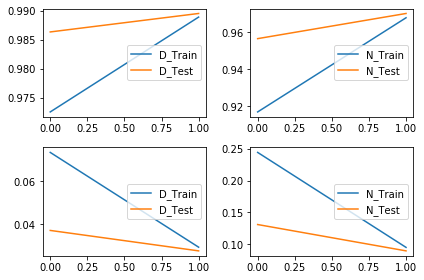

In [9]:
fig, ax = plt.subplots(nrows=2, ncols=2)

for n, v in enumerate(['accuracy', 'loss'], 0):
    for n1, t in enumerate(['D', 'N'], 0):
        p = ax[n][n1]
        p.plot(history.history[t + '_' + v][0:])
        p.plot(history.history['val_' + t + '_' +  v][0:])
        p.legend([t + '_Train', t + '_Test'], loc='center right')

plt.tight_layout()

In [10]:
def print_predictions(k):
    s = slice(k*BATCH_SIZE, (k+1)*BATCH_SIZE)
    batch = data.input_validation[s]
    [actual_niqqud, actual_dagesh] = dataset.from_categorical(model.predict(batch))
    [expected_niqqud, expected_dagesh] = [data.niqqud_validation[s], data.dagesh_validation[s]]
    actual = data.merge(batch, ns=actual_niqqud, ds=actual_dagesh)
    expected = data.merge(batch, ns=expected_niqqud, ds=expected_dagesh)
    for a, e in zip(actual, expected):
        print(a)
        print(e)
        print()

print_predictions(1)

הַשַּבָּת, סְפֵק שְאֵינוּ צָרִיךְ, וְכֵן אִם אָמַר רוֹפֵא לְחַלַּל עָלָיו אֶת הַשַּבָּת,
הַשַּבָּת, סְפֵק שְאֵינוּ צָרִיךְ, וְכֵן אִם אָמַר רוֹפֵא לְחַלַּל עָלָיו אֶת הַשַּבָּת,

עַבְדְּךָ מִתְפַּלֵּל לְפָנֶיךָ לִהְיוֹת עֵינֶיךָ פְּתְחוֹת אֶל-הַבַּיִת הַזֶּה יוֹמָם וָלַיְלָה
עַבְדְּךָ מִתְפַּלֵּל לְפָנֶיךָ לִהְיוֹת עֵינֶיךָ פְתֻחוֹת אֶל-הַבַּיִת הַזֶּה יוֹמָם וָלַיְלָה

הַתַּנּוּר, הוּא הַנִּקְרָא סְרִידָה. [ט] תַּנּוּר יָשָן בְּתוֹךְ הַחֹדֶש, וּסְרִידָה עַל
הַתַּנּוּר, הוּא הַנִּקְרָא סְרִידָה. [ט] תַּנּוּר יָשָן בְּתוֹךְ הֶחָדָש, וּסְרִידָה עַל

וּמְרַבְּצִין אֶת הַשָּדֶה בַּמּוֹעֵד. שֶכָּל הַדְּבָרִים הָאֵלּוּ, אֵין בָּהֶן טֹרַח יָתֵר.
וּמְרַבְּצִין אֶת הַשָּדֶה בַּמּוֹעֵד. שֶכָּל הַדְּבָרִים הָאֵלּוּ, אֵין בָּהֶן טֹרַח יָתֵר.

מוֹאָב עַל יַרְדֵּן יְרֵחוֹ וַיַּחֲנוּ עַל-הַיַּרְדֵּן מִבֵּית הַיּשֶמְת עַד אֲבָל הַשִּטִּים
מוֹאָב עַל יַרְדֵּן יְרֵחוֹ וַיַּחֲנוּ עַל-הַיַּרְדֵּן מִבֵּית הַיְשִמֹת עַד אָבֵל הַשִּטִּים

שֶהָרְאָה מֵעַצְמוֹ, לֹא שְבוּעָה חֲמוּרָה וְלֹא שְבוּעַת הֶסֵּת, מִפּ